### Shock Cooling Emission (SCE) Type IIb Supernova Metric Implementation

The `ShockCoolingType2b` suite of metrics explores how well LSST can detect and characterize **shock-cooling emission peaks** in Type IIb supernovae, with particular attention to identifying **double-peaked light curves**. These peaks reflect an early, short-lived shock-cooling flash followed by the longer, radioactive-powered peak.

The light curve starts with an immediate rise toward the shock-cooling peak—there's no flat, constant-brightness phase before it. This mirrors real Type IIb SNe like ZTF18aalrxas and SN 2021vgn, which show rapid early brightening without a visible pre-flash plateau. 

### 1. Light Curve Modeling

**Class:** `ShockCoolingLC`

- Simulates synthetic light curves in **g** and **r** bands.
- Models four key phases:
  - **Initial rise** to the shock-cooling peak,
  - **Short plateau** (duration at peak),
  - **Fade** after the peak,
  - **Re-rise** to the nickel-powered second peak.
- Parameters (rise/fade rates, magnitudes) are drawn from distributions based on real SNe IIb (e.g., ZTF18aalrxas, SN 2021vgn).
- Each light curve template represents a different realization of plausible SCE behavior.

### 2. Detection Criteria

**Function:** `evaluate_sce()`

- An event is **detected** if:
  - There are **≥2 observations in the same filter**,
  - Each is detected at **≥5σ**, and
  - The observations are **≥0.5 days apart**.
  
This aims to reject false positives (e.g., noise or fast-moving solar system objects).

### 3. Characterization Criteria

**Function:** `characterize_sce()`

Classifies how well each light curve is sampled in time:

- **Classical**: ≥2 observations with SNR ≥0.5 in **each phase**:
  - Rise (−3 to 0 days),
  - Fade (0 to 7 days),
  - Re-rise (7 to 13 days).
- **Ambiguous**: ≥6 observations with SNR ≥0.5 but not spread across all three phases.
- **Uncharacterized**: <6 total detections with SNR ≥0.5.

This phase-based scheme ensures we can interpret the transient structure, not just detect it.

### 4. Double-Peak Identification

- A **second peak** is flagged if:
  - There are ≥2 observations between **7 and 13 days** post-peak,
  - Each has SNR ≥0.5.

This helps identify SNe IIb with strong shock-cooling and radioactive components.

### 5. Population Generation Based on Volumetric Rate

**Function:** `generateShockCoolingType2bSlicer()`

**Questions here regarding population

- Volumetric rate basis:
  - ~10–11% of CCSNe are Type IIb.
  - Rubin is expected to detect ~1 million SNe/year → ~65,000 SNe IIb/year.
- Over 10 years: **~650,000 synthetic events**.

Each synthetic event includes:

- RA/Dec (uniform sphere),
- Distance (10–300 Mpc),
- Explosion time (days 1–3652),
- One of 100 synthetic light curve templates (`file_indx`),
- Extinction value `E(B–V)` from `SFDQuery()`.

### 6. Dust Extinction Correction

- Line-of-sight extinction queried from SFD dust maps.
- Extinction applied using `ax1` values from `DustValues()` for each band.

### 7. Metric Subclasses

Each metric subclass evaluates a specific detection or classification condition:

- `ShockCoolingType2bDetectMetric`: Did this event meet the detection threshold?
- `ShockCoolingType2bCharacterizeMetric`: Was this event **fully characterized** (i.e., classical)?
- `ShockCoolingType2bClassicalMetric`: Specifically flags **classical** events.
- `ShockCoolingType2bAmbiguousMetric`: Event is **ambiguous** (not fully phase-sampled).
- `ShockCoolingType2bUncharacterizedMetric`: Event is **undersampled** (<6 SNR ≥0.5).
- `ShockCoolingType2bDoublePeakMetric`: Event shows a **second peak** in light curve.

### 8. Sky Map Plotting and Output Files

- Metrics grouped and visualized using `MetricBundleGroup` and `HealpixSkyMap`.
- Results saved in:
  - `efficiency_<cadence>_shockcooling.csv`: Summary efficiency stats.
  - `type2b_phases_<cadence>_shockcooling.csv`: Per-event classification results.

### 9. How the Code Works Step-by-Step

1. **Generate Population**:
   - `generateShockCoolingType2bSlicer()` simulates ~650,000 events across the sky with distance, explosion time, extinction, and template index.

2. **Assign Light Curves**:
   - Each event is assigned a synthetic light curve based on randomized SCE parameters.

3. **Extract Observations**:
   - The metric evaluates LSST observations (`dataSlice`) within the region and time window of each event.

4. **Compute Apparent Magnitudes**:
   - For each observation, interpolate the light curve and apply extinction.

5. **Calculate SNR and Apply Criteria**:
   - Use `m52snr()` to calculate SNR from magnitude and 5σ depth.
   - Check detection and characterization conditions.

6. **Save Results and Plot**:
   - Metrics are stored per event and used to generate efficiency CSVs and sky map visualizations.

### 10. Design Philosophy and Rationale

- **Population size** reflects expected SNe IIb rates.
- **Detection logic** is simple and avoids transient confusion.
- **Phase-based classification** helps ensure we understand the structure of the light curve.
- **Double-peak detection** enables testing early-time science capabilities.
- **Consistent extinction treatment** makes the metric robust and compatible with Rubin tools.

### 11. Example: Classical Event

A synthetic SN IIb in the g-band might be observed:

At day −2 and +0.5 with SNR >5 → Detected.

At day −2, +0.5, +3, +5, +8, and +11 with SNR >0.5 → Classical.

Two of those detections fall between day +7 and +13 → Double peak flagged.

This meets all conditions for detection, characterization, and double-peak tagging.




In [1]:
%matplotlib inline
import sys
import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
sys.path.append(os.path.abspath(".."))
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim import maf
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp

from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [2]:



def equatorialFromGalactic(lon, lat):
    gal = Galactic(l=lon * u.deg, b=lat * u.deg)
    equ = gal.transform_to(ICRS)
    return equ.ra.deg, equ.dec.deg

def hpid2RaDec(nside, hpidx):
    theta, phi = hp.pix2ang(nside, hpidx, nest=False)
    ra = np.degrees(phi)
    dec = 90.0 - np.degrees(theta)
    return ra, dec

def healbin(lon, lat, nside=64, nest=False):
    theta = np.radians(90. - lat)
    phi = np.radians(lon)
    return hp.ang2pix(nside, theta, phi, nest=nest)

_healbin = healbin

#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [3]:
##RUN TWICE

import sys
import importlib

if "local_ShockCoolingType2b" in sys.modules:
    del sys.modules["local_ShockCoolingType2b"]
import local_ShockCoolingType2b
importlib.reload(local_ShockCoolingType2b)

from local_ShockCoolingType2b import (
    ShockCoolingType2bDetectMetric,
    ShockCoolingType2bCharacterizeMetric,
    ShockCoolingType2bClassicalMetric,
    ShockCoolingType2bAmbiguousMetric,
    ShockCoolingType2bUncharacterizedMetric,
    ShockCoolingType2bDoublePeakMetric,
    generateShockCoolingType2bSlicer,
    ShockCoolingLC,
    generateSCETemplates
)
print(local_ShockCoolingType2b.__file__)

/Users/fbianco/Transient_Metrics_Hub/Multi_Transient_Metrics_Hub/ShockCooling/local_ShockCoolingType2b.py


/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric local_ShockCoolingType2b.BaseShockCoolingType2bMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric local_ShockCoolingType2b.ShockCoolingType2bDetectMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric local_ShockCoolingType2b.ShockCoolingType2bCharacterizeMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))


Found existing SCE templates at ShockCooling_templates.pkl. Not regenerating.


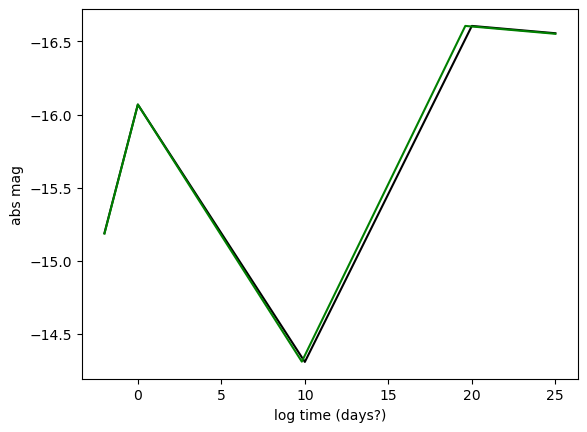

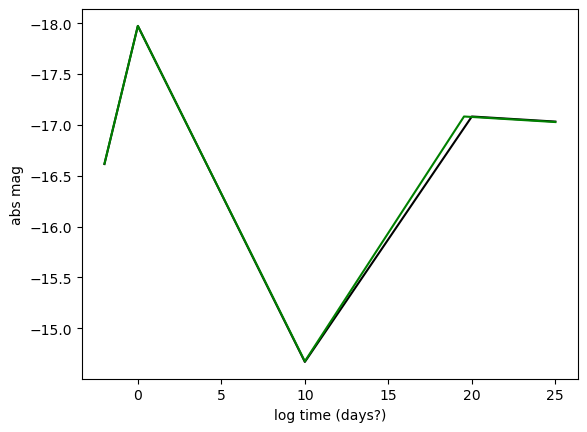

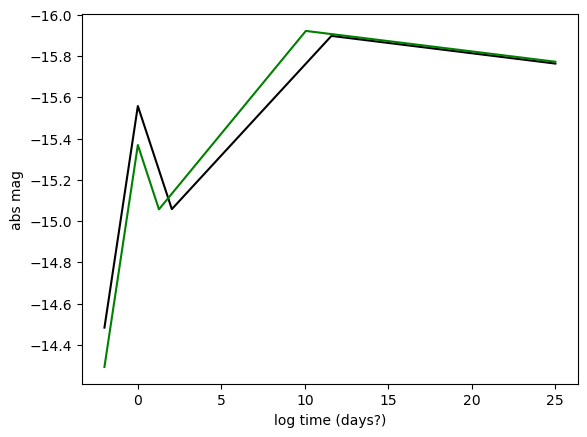

In [18]:

cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
# --- Metric Configuration ---
dmin = 10       # Minimum luminosity distance in Mpc
dmax = 300      # Maximum luminosity distance in Mpc
rate_per_year = 65_000  # Based on LOSS + LSST projection
rate_str = "%s"%rate_per_year
gal_lat_cut = None
sc_dir = f"ShockCooling_fixedpop_detectonly/{rate_str}"
shockcooling_template_file = "ShockCooling_templates.pkl"
db_dir = "../"



t_start, t_end= 1, 3652

# --- Output Files ---
typefile = f"AllTransient_MetricDetection/Types_csv/type2b_phases_shockcooling.csv"
pop_file = f"ShockCooling_population_{rate_per_year}.pkl"
shared_lc_model = generateSCETemplates(save_to=shockcooling_template_file)


lcdict = pickle.load(open("ShockCooling_templates.pkl", "rb"))


for i in np.random.uniform(0,100,3).astype(int):
    plt.plot((lcdict["lightcurves"][i]['g']['ph']),
                     lcdict["lightcurves"][i]['g']['mag'], color='k')
    plt.plot((lcdict["lightcurves"][i]['r']['ph']),
                      lcdict["lightcurves"][i]['r']['mag'], color='g')
    ylims = plt.ylim()
    plt.xlabel("log time (days?)")
    plt.ylabel("abs mag")
    plt.ylim(*ylims[::-1])
    plt.show()


In [21]:
#lcdict["lightcurves"][56]
#, 56 1.5 4.99 6.0
lcdict['durations']


{'g': {'rise': [2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0],
  'fade': [3.3821382641288875,
   10.0,
   10.0,
   10.0,
   10.0,
   6.347314313360947,
   1.3671016226996129,
   1.666858907062224,
   10.0,
   10.0,
   10.0,
   7.261607086837341,
   

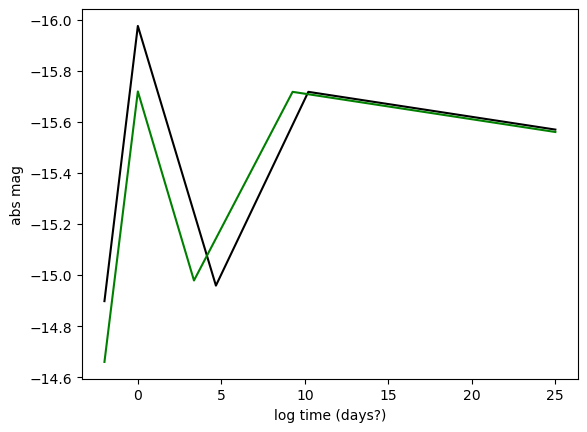

In [12]:
i = 56
plt.plot((lcdict["lightcurves"][i]['g']['ph']),
                     lcdict["lightcurves"][i]['g']['mag'], color='k')
plt.plot((lcdict["lightcurves"][i]['r']['ph']),
                          lcdict["lightcurves"][i]['r']['mag'], color='g')
ylims = plt.ylim()
plt.xlabel("log time (days?)")
plt.ylabel("abs mag")
plt.ylim(*ylims[::-1])
plt.show()

In [13]:


    
# ---- Template Setup ----
if not os.path.exists(shockcooling_template_file):
    from local_ShockCoolingType2b import generateShockCoolingType2bSlicer
    generateShockCoolingType2bSlicer(save_to=pop_file)
shared_lc_model = generateSCETemplates(save_to=shockcooling_template_file)


# ---- Population Setup ----
if not os.path.exists(pop_file):
    slicer = generateShockCoolingType2bSlicer(
        t_start=t_start, t_end=t_end, seed=42,
        d_min=dmin, d_max=dmax, num_lightcurves=100,
        gal_lat_cut=gal_lat_cut, rate_per_year=rate_per_year,
        save_to=pop_file
    )
else:
    slicer = generateShockCoolingType2bSlicer(load_from=pop_file)


n_events = len(slicer.slice_points['distance'])
print("generated", n_events)

Found existing SCE templates at ShockCooling_templates.pkl. Not regenerating.
Loaded SC population from ShockCooling_population_65000.pkl
generated 649733



--- Running four_roll_v4.3.1_10yrs ---
Total Shock Cooling events simulated: 649733
Sample distances (Mpc): [234.44725408 137.27474753 258.99339677 212.23672843  37.31143089]
ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
[DEBUG] Detected RA, Dec: 180.00, -20.11
[DEBUG] Detected RA, Dec: 350.86, -3.58
[DEBUG] Detected RA, Dec: 336.09, -12.64
[DEBUG] Detected RA, Dec: 60.47, -66.44
[DEBUG] Detected RA, Dec: 133.59, -23.97
[DEBUG] Detected RA, Dec: 185.92, -61.94
[DEBUG] Detected RA, Dec: 118.83, -1.19
[DEBUG] Detected RA, Dec: 118.83, -10.81
[DEBUG] Detected RA, Dec: 30.94, -5.38
[DEBUG] Detected RA, Dec: 26.02, -38.68
[DEBUG] Detected RA, Dec: 277.03

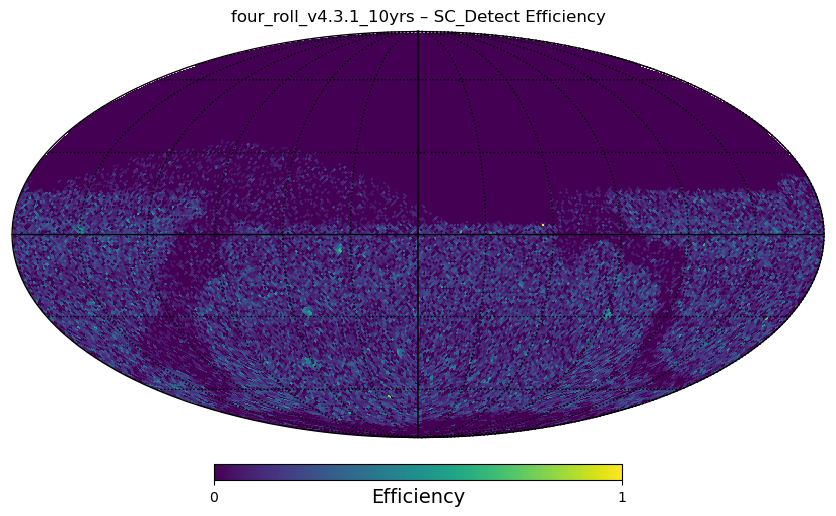

[DEBUG] Detected RA, Dec: 177.19, 1.79
[DEBUG] Detected RA, Dec: 167.34, -25.28
[DEBUG] Detected RA, Dec: 36.20, -55.87
[DEBUG] Detected RA, Dec: 147.66, -34.95
[DEBUG] Detected RA, Dec: 102.66, 25.28
[DEBUG] Detected RA, Dec: 185.62, -20.11
[DEBUG] Detected RA, Dec: 320.63, -60.43
[DEBUG] Detected RA, Dec: 4.92, -24.62
[DEBUG] Detected RA, Dec: 104.77, 7.18
[DEBUG] Detected RA, Dec: 117.42, 23.32
[DEBUG] Detected RA, Dec: 196.17, -27.28
[DEBUG] Detected RA, Dec: 85.78, -34.95
Detected 11422.0 out of 649733.0


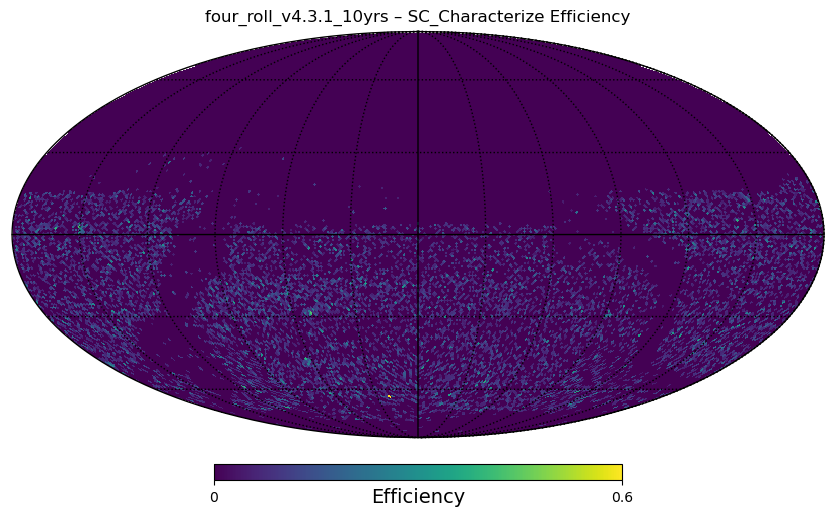

[DEBUG] Detected RA, Dec: 62.23, -55.11
[DEBUG] Detected RA, Dec: 249.61, 12.02
[DEBUG] Detected RA, Dec: 20.39, -18.21
[DEBUG] Detected RA, Dec: 304.91, -46.57
[DEBUG] Detected RA, Dec: 264.38, -60.43
Detected 3959.0 out of 649733.0


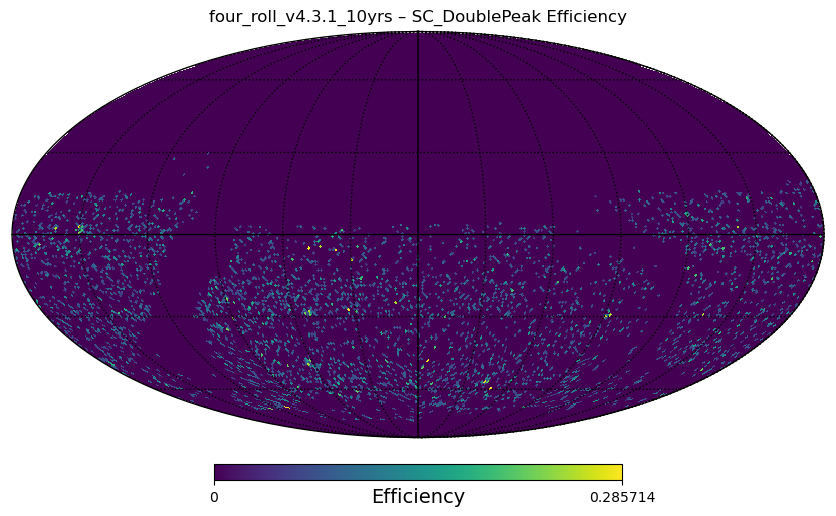

In [14]:
first = 1
for cadence in cadences[1:]:
    print(f"\n--- Running {cadence} ---")

    # --- Output Files ---
    outfile = f"AllTransient_MetricDetection/local_efficiency_{cadence}_shockcooling.csv"


    # --- Load Cadence DB ---
    print(f"Total Shock Cooling events simulated: {n_events}")
    print(f"Sample distances (Mpc): {slicer.slice_points['distance'][:5]}")
    
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    if not os.path.exists(opsdb):
        raise FileNotFoundError(f"Cadence database not found: {opsdb}")
    outDir = os.path.join(sc_dir, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = db.ResultsDb(out_dir=outDir)


    #detect = ShockCoolingType2bDetectMetric(metricName=f"SC_detect"), #filter_include=[filt], 
                                         #lc_model=shared_lc_model)
                    #GRBAfterglowSpecTriggerableMetric(metricName=f"GRB_Detect_{filt}", filter_include=[filt], 

    multi_metrics = [
        ShockCoolingType2bDetectMetric(metricName="SC_Detect"),#, lc_model=shared_lc_model),
        ShockCoolingType2bCharacterizeMetric(metricName="SC_Characterize"),
        ShockCoolingType2bDoublePeakMetric(metricName="SC_DoublePeak")
        #GRBAfterglowBetterDetectMetric(metricName="GRB_BetterDetect__MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
    ]



    for metric in multi_metrics:
        mb_key = f"{cadence}_{metric.__class__.__name__}"
        bundle = metric_bundles.MetricBundle(metric, slicer, '', file_root=mb_key, plot_funcs=[], summary_metrics=[metrics.SumMetric()])
        
        bd = maf.metricBundles.make_bundles_dict_from_list([bundle])
        bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        bgroup.run_all()
        if first:
            df = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            df["run"] = cadence
            first = 0
        else:
            _ = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            _["run"] = cadence            
            df = pd.concat([df, _])
        # Healpix plotting

        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = slicer.slice_points['ra']
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)

        #print(f"[DEBUG] RA range [rad]: {ra_rad.min():.2f} – {ra_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [rad]: {dec_rad.min():.2f} – {dec_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [deg]: {np.degrees(dec_rad).min():.2f} – {np.degrees(dec_rad).max():.2f}")
        
        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            #if detected_flags[i] :
            if bundle.metric_values[i] == 1:
                if np.random.rand() < 0.001:
                    print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN
        print(f"Detected {detected_map[mask].sum()} out of {injected_map.sum()}")
        hp.mollview(eff_map, title=f"{cadence} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.show()




In [15]:
df

,Sum,run
four_roll_v4.3.1_10yrs_ShockCoolingType2bDetectMetric,46036.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_ShockCoolingType2bCharacterizeMetric,11422.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_ShockCoolingType2bDoublePeakMetric,3959.0,four_roll_v4.3.1_10yrs



--- Running baseline_v4.3.1_10yrs ---
Total Shock Cooling events simulated: 649733
Sample distances (Mpc): [234.44725408 137.27474753 258.99339677 212.23672843  37.31143089]
ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
ShockCooling_templates.pkl
Loaded 100 shock cooling light curves from ShockCooling_templates.pkl
[DEBUG] Detected RA, Dec: 171.56, -4.18
[DEBUG] Detected RA, Dec: 215.16, -10.20
[DEBUG] Detected RA, Dec: 123.75, 5.38
[DEBUG] Detected RA, Dec: 5.62, -5.38
[DEBUG] Detected RA, Dec: 111.80, 12.02
[DEBUG] Detected RA, Dec: 298.83, -28.63
[DEBUG] Detected RA, Dec: 87.89, -20.74
[DEBUG] Detected RA, Dec: 218.15, -55.87
[DEBUG] Detected RA, Dec: 162.42, -30.00
[DEBUG] Detected RA, Dec: 309.38, -29.31
[DEBUG] Detected RA, Dec: 239.06, -

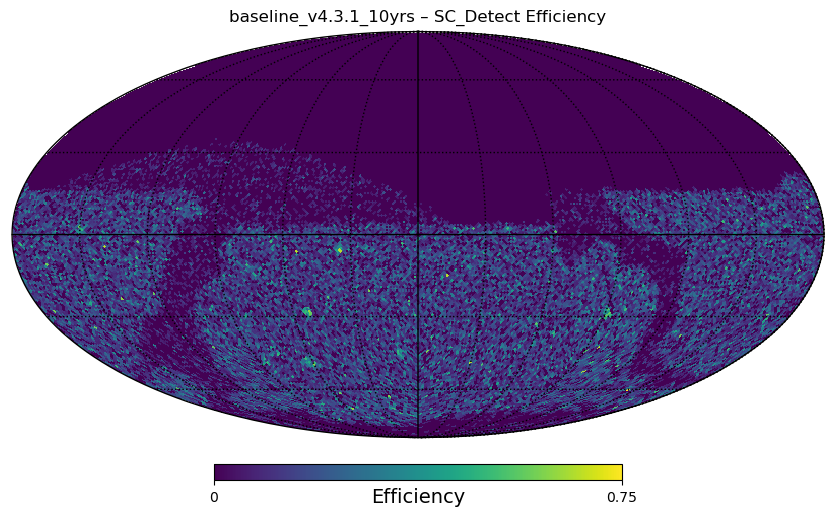

[DEBUG] Detected RA, Dec: 355.08, -5.98
[DEBUG] Detected RA, Dec: 270.85, -50.48
[DEBUG] Detected RA, Dec: 275.62, 8.99
[DEBUG] Detected RA, Dec: 291.09, -21.38
[DEBUG] Detected RA, Dec: 51.33, -34.23
[DEBUG] Detected RA, Dec: 180.00, -7.78
[DEBUG] Detected RA, Dec: 129.38, -29.31
[DEBUG] Detected RA, Dec: 337.50, -11.42
[DEBUG] Detected RA, Dec: 20.39, -5.98
[DEBUG] Detected RA, Dec: 158.62, -60.43
[DEBUG] Detected RA, Dec: 33.05, -15.71
[DEBUG] Detected RA, Dec: 174.37, -8.99
[DEBUG] Detected RA, Dec: 320.63, -8.99
Detected 11246.0 out of 649733.0


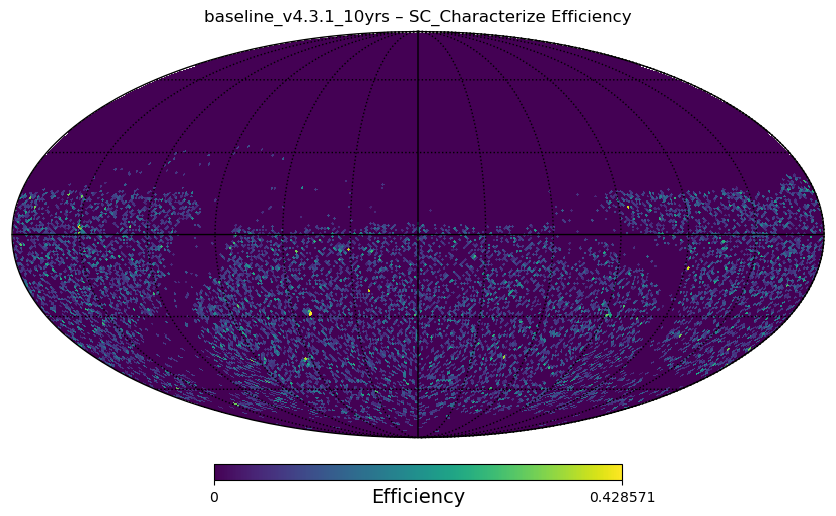

[DEBUG] Detected RA, Dec: 298.12, 7.78
[DEBUG] Detected RA, Dec: 205.36, -48.92
[DEBUG] Detected RA, Dec: 201.80, -35.69
Detected 3641.0 out of 649733.0


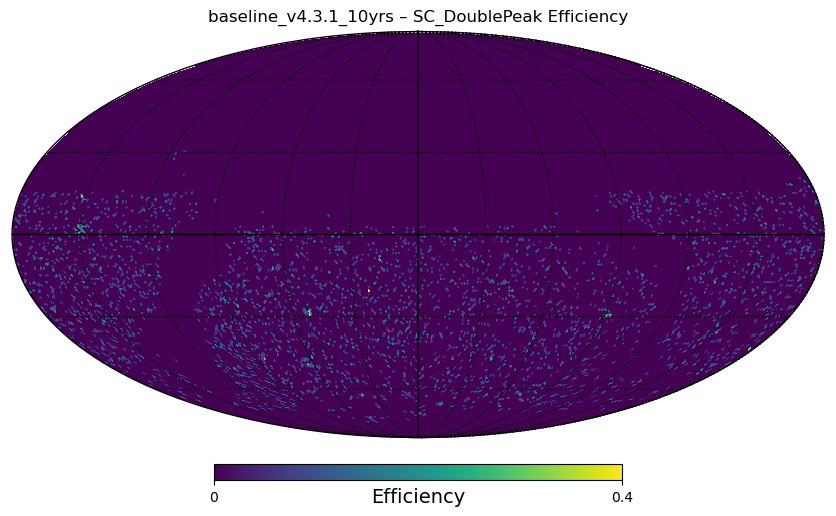

In [16]:
first = 1
for cadence in cadences[1:]:
    print(f"\n--- Running {cadence} ---")

    # --- Output Files ---
    outfile = f"AllTransient_MetricDetection/local_efficiency_{cadence}_shockcooling.csv"


    # --- Load Cadence DB ---
    print(f"Total Shock Cooling events simulated: {n_events}")
    print(f"Sample distances (Mpc): {slicer.slice_points['distance'][:5]}")
    
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    if not os.path.exists(opsdb):
        raise FileNotFoundError(f"Cadence database not found: {opsdb}")
    outDir = os.path.join(sc_dir, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = db.ResultsDb(out_dir=outDir)


    detect = ShockCoolingType2bDetectMetric(metricName=f"SC_detect"), #filter_include=[filt], 
                                         #lc_model=shared_lc_model)
                    #GRBAfterglowSpecTriggerableMetric(metricName=f"GRB_Detect_{filt}", filter_include=[filt], 

    multi_metrics = [
        ShockCoolingType2bDetectMetric(metricName="SC_Detect"),#, lc_model=shared_lc_model),
        ShockCoolingType2bCharacterizeMetric(metricName="SC_Characterize"),
        ShockCoolingType2bDoublePeakMetric(metricName="SC_DoublePeak")
        #GRBAfterglowBetterDetectMetric(metricName="GRB_BetterDetect__MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
    ]



    for metric in multi_metrics:
        mb_key = f"{cadence}_{metric.__class__.__name__}"
        bundle = metric_bundles.MetricBundle(metric, slicer, '', file_root=mb_key, plot_funcs=[], summary_metrics=[metrics.SumMetric()])
        
        bd = maf.metricBundles.make_bundles_dict_from_list([bundle])
        bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        bgroup.run_all()
        if first:
            df = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            df["run"] = cadence
            first = 0
        else:
            _ = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            _["run"] = cadence            
            df = pd.concat([df, _])
        # Healpix plotting

        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = slicer.slice_points['ra']
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)

        #print(f"[DEBUG] RA range [rad]: {ra_rad.min():.2f} – {ra_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [rad]: {dec_rad.min():.2f} – {dec_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [deg]: {np.degrees(dec_rad).min():.2f} – {np.degrees(dec_rad).max():.2f}")
        
        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            #if detected_flags[i] :
            if bundle.metric_values[i] == 1:
                if np.random.rand() < 0.001:
                    print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN
        print(f"Detected {detected_map[mask].sum()} out of {injected_map.sum()}")
        hp.mollview(eff_map, title=f"{cadence} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.show()




In [17]:
df


,Sum,run
baseline_v4.3.1_10yrs_ShockCoolingType2bDetectMetric,46438.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_ShockCoolingType2bCharacterizeMetric,11246.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_ShockCoolingType2bDoublePeakMetric,3641.0,baseline_v4.3.1_10yrs
